In [1]:
import os
import random
import sys
from collections import Counter
from typing import Dict, Iterable

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import SGD
from torch.utils.data import DataLoader, Dataset
from IPython.display import clear_output

In [2]:
BATCH_SIZE = 2
LR = 1.0
EPOCHS = 5
TRAIN_FILE_NAME = 'https://stepik.org/media/attachments/lesson/697770/descriptions.csv'

# размерность векторного представления слова
EMB_DIM = 2

# минимальная частота, необходимая для включения токена в словарь
MIN_COUNT = 4

# максимальное расстояние между центральным и контекстным словом
SKIPGRAM_WORDS = 4

# максимальная норма векторного представления
MAX_NORM = 2

# слова, которые будут использоваться для визуализации обучения
WORDS_TO_ANNOTATE = ('iphone', 'айфон', 'кошка', 'кошечка', 'куртка', 'ветровка')

# частота (в количесте описаний), с которой будут отображаться вектора во время обучения
VISUALIZATION_FREQUENCY = 200

In [3]:
class DescriptionDataset(Dataset):
    
    def __init__(self, corpus: Iterable[str]):
        self.corpus = corpus
        self.vocab = self._build_vocab()

    def __len__(self):
        return len(self.corpus)

    def __getitem__(self, idx):
        description = self.corpus[idx]

        # заменяем каждое слово на его айди, если оно есть в словаре, иначе ставим -1
        tokens_ids = [self.vocab.get(word, -1) for word in description.strip().split()]
        batch_input, batch_output = [], []

        # пробегаем все центральные слова
        for i, central_word_id in enumerate(tokens_ids):

            # для каждого центрального слова пробегаем его соседей
            for context_word_id in tokens_ids[max(i - SKIPGRAM_WORDS, 0) : i + SKIPGRAM_WORDS + 1]:

                # берем только те пары, где центральное слово отлично от контекстного и каждое слово из словаря
                if (
                    central_word_id == context_word_id
                    or central_word_id == -1
                    or context_word_id == -1
                ):
                    continue
                batch_input.append(central_word_id)
                batch_output.append(context_word_id)
        return batch_input, batch_output

    def _build_vocab(
        self,
    ) -> Dict[str, int]:
        words = [word for sentence in self.corpus for word in sentence.split()]
        word_frequency = Counter(words)
        vocab = {}
        word_id = 0
        for word, frequency in word_frequency.items():
            if frequency < MIN_COUNT:
                continue
            vocab[word] = word_id
            word_id += 1
        return vocab

    @staticmethod
    def collate_skipgram(batches):
        all_center = [center for batch in batches for center in batch[0]]
        all_context = [context for batch in batches for context in batch[1]]
        return torch.LongTensor(all_center), torch.LongTensor(all_context)

In [4]:
class Skipgram(nn.Module):
    
    def __init__(self, vocab_size: int, emb_dimension: int):
        super().__init__()
        self.embeddings = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=emb_dimension,
            max_norm=MAX_NORM,
        )
        self.linear = nn.Linear(
            in_features=emb_dimension,
            out_features=vocab_size,
        )

    def forward(self, x):
        x = self.embeddings(x)
        x = self.linear(x)
        return x

In [5]:
def show_words(model: nn.Module, vocab: Dict[str, int], words_to_annotate: tuple, title: str):
    mask = np.isin(list(vocab.keys()), words_to_annotate)
    embeddings = list(model.parameters())[0][mask]
    embeddings = embeddings.cpu().detach().numpy()
    clear_output(True)
    plt.figure(figsize=(15, 15), dpi=80)
    plt.scatter(embeddings[:, 0], embeddings[:, 1])
    for idx, vector in enumerate(embeddings):
        plt.annotate(words_to_annotate[idx], (vector[0], vector[1]), alpha=1.0, fontsize=20)
    plt.title(title, fontsize = 16)
    plt.xlim([-MAX_NORM - 1, MAX_NORM + 1])
    plt.ylim([-MAX_NORM - 1, MAX_NORM + 1])
    plt.show()

In [6]:
class Trainer:

    def __init__(
            self,
            model,
            epochs,
            dataloader,
            criterion,
            optimizer,
            batch_size,
            initial_lr,
    ):

        self.model = model
        self.epochs = epochs
        self.dataloader = dataloader
        self.criterion = criterion
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.initial_lr = initial_lr

    def train(self):
        for epoch in range(self.epochs):
            self._train_epoch(epoch)

    def _train_epoch(self, epoch):
        self.model.train()

        for idx, batch_data in enumerate(self.dataloader):
            sentences_passed = idx * BATCH_SIZE
            if sentences_passed % VISUALIZATION_FREQUENCY == 0:
                show_words(self.model, self.dataloader.dataset.vocab, WORDS_TO_ANNOTATE,
                           f'Epoch - {epoch}, sentences passed - {sentences_passed}')

            inputs = batch_data[0]
            labels = batch_data[1]

            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

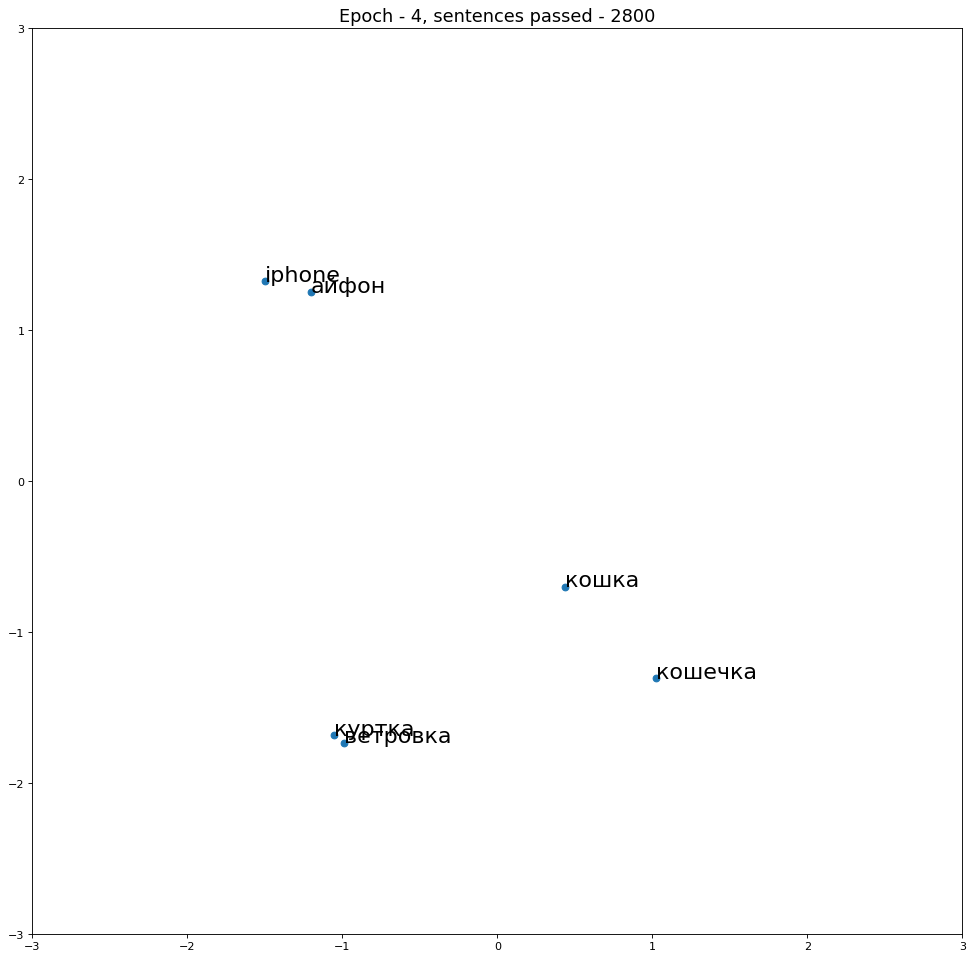

In [7]:
seed_everything()

corpus = pd.read_csv(TRAIN_FILE_NAME, index_col='index')['description']
dataset = DescriptionDataset(corpus=corpus)

dataloader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=dataset.collate_skipgram,
)

vocab_size = len(dataset.vocab)

model = Skipgram(vocab_size=vocab_size, emb_dimension=EMB_DIM)
criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=LR)

trainer = Trainer(
    model=model,
    epochs=EPOCHS,
    dataloader=dataloader,
    criterion=criterion,
    optimizer=optimizer,
    batch_size=BATCH_SIZE,
    initial_lr=LR,
)
trainer.train()